In [1]:
using EVQueues, Plots, Distributions
#using Pkg; Pkg.instantiate()

In [97]:
#Parámetros del resto de la simulación
lambda=10.0;
mu=1;
gamma=1;
C=5.0;
Tfinal=100.0;

#Se agrega snaps para hacer animaciones
#snaps = collect(0.1:0.1:Tfinal);

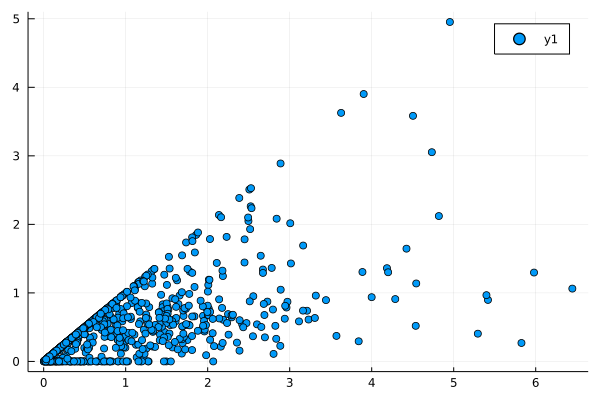

In [98]:
function hybridpolicy(evs,C::Float64)
    #Asigno el 70% de la potencia para EDF y el 30% para FIFO (asumo que el 30% no reportan deadline)
    C_edf=0.7*C;
    C_fifo=0.3*C;
    
    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        p=0.0;
        p_fifo=0.0;
        p_edf=0.0;        
        i=1;
        U=zeros(length(evs));
        
        deadlines = [ev.currentReportedDeadline for ev in evs];
        #show(deadlines)
        perm = sortperm(deadlines)

        
        #Identifico los VE cuyos deadline no esta reportado
        k=findall(x->x==Inf, deadlines)
        show(k)
        j=findfirst(x->x==k[1], perm)

        
        #Separo en un nuevo array todos los vehiculos con deadline reportado
        ev_edf=perm[1:j-1]
               
        while p_fifo<C_fifo && i<=length(evs)
            if deadlines[i]==Inf
                alloc = min(evs[i].chargingPower,C_fifo-p_fifo);
                p_fifo=p_fifo+alloc;
                U[i]=alloc;
                i=i+1
            else
                i=i+1
            end
        end
        i=1
        while p_edf<C_edf && i<=length(evs)
            alloc = min(evs[perm[i]].chargingPower,C_edf-p_edf);
            p_edf=p_edf+alloc;
            U[perm[i]]=alloc;
            i=i+1
        end
    end
    return U;
end


df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

#El 30% de los usuarios no reportan deadline
function no_deadline()
    random = rand()
    if random<0.3
        return Inf
    else
        return 0
    end
end
reportedDeadlines = [d+no_deadline() for d in df[!,:salidas]]
df[:salidaReportada] = reportedDeadlines
#show(reportedDeadlines)

hybrid_policy = ev_sim_trace(df,hybridpolicy,C,[Inf]);
compute_statistics!(hybrid_policy);

hybrid_policy_evs = sort(hybrid_policy.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
hybrid_policy_evs = hybrid_policy_evs[n:end-n]

#Guardo resultados de vehiculos
S = [ev.requestedEnergy for ev in hybrid_policy_evs];
Sr = [ev.departureWorkload for ev in hybrid_policy_evs];
Sa = S - Sr

scatter(S,Sa)



In [82]:
df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

#El 30% de los usuarios no reportan deadline
function no_deadline()
    random = rand()
    if random<0.3
        return Inf
    else
        return 0
    end
end

a = rand(1,10)
a = [x+no_deadline() for x in a]
a=vec(a)
show(a);

perm = sortperm(a);
show(perm);
        
k=findfirst(x->x==Inf, a)
show(k)

j=findfirst(x->x==k, perm)
show(j)

ev_edf=perm[1:j-1]
show(ev_edf)


[Inf, 0.30161967885036045, Inf, 0.45483733905695023, 0.7394741586777709, Inf, 0.715020044659296, 0.26640351337873214, 0.4681261626873492, 0.7523678966861722][8, 2, 4, 9, 7, 5, 10, 1, 3, 6]18[8, 2, 4, 9, 7, 5, 10]